# Predictive modeling:
Predictive modeling is the process by which a model is created to predict an outcome. If the outcome is categorical it is called classification and if the outcome is numerical it is called regression.  Descriptive modeling or clustering is the assignment of observations into clusters so that observations in the same cluster are similar. Finally, association rules can find interesting associations amongst observations.In this particular case we are going to discuss a classification modeling case.

## Context
It is important that e-commerce companies are able to recognize fraudulent transactions so that customers are not charged for items that they did not purchase.

### Problem Statement
Identify if a particular transaction is fraudulent or not. It is a binomial classification problem.

### Data Preparation
The data set contains 2 different data files:
1 Transactional_dataset.csv
2 Network_dataset.csv
The whole dataset is a combination of both categorical and numerical variables. The dataset presents transactions that occurred between a merchant and a customer of an e-commerce company, where the e-commerce Company plays the role of a market place. Our ultimate motive is to build/train a model on the given dataset which will be able to predict if a transaction is fraudulent or not.
We will be using Python for solving this machine learning problem. Let’s start with loading the dataset in python.

In [1]:
#Import required Packages
import pandas as pd
import os
import logging

# Configure Logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

""" Load Data set """
def load_data(foldername):
    
    """ Read input data """
    input_dir = os.path.join(os.pardir, foldername)
    logger.info('Input files:\n{}'.format(os.listdir(input_dir)))
    logger.info('Loading data sets...')
    sample_size = None
    Transactional_df = pd.read_csv(os.path.join(input_dir, 'Transactional_dataset.csv'), nrows=sample_size).reset_index()
    Network_df = pd.read_csv(os.path.join(input_dir, 'Network_dataset.csv'), nrows=sample_size).reset_index()
    logger.info('Data loaded.')
    logger.info('Main application Transactional data set shape = {}'.format(Transactional_df.shape))
    logger.info('Main application Network data set shape = {}'.format(Network_df.shape))

    return Transactional_df, Network_df

foldername = 'data'
Transactional_df, Network_df = load_data(foldername)

INFO:__main__:Input files:
['Network_dataset.csv', 'Transactional_dataset.csv']
INFO:__main__:Loading data sets...
INFO:__main__:Data loaded.
INFO:__main__:Main application Transactional data set shape = (594643, 11)
INFO:__main__:Main application Network data set shape = (594643, 6)


### Merging Data
Now we will have to merge these files into 1 file based on the common ids/ columns in both the files.
If we closely have a look at both the data files, we will understand that there are different column names for merchant data and customer data in both the files. We simply create a common_id in both files which concatenates all the common columns in both the files in order.

In [2]:
Transactional_df['common_id'] = Transactional_df['index'].astype('str') + Transactional_df['customer'].astype('str') + Transactional_df['merchant'].astype('str') + Transactional_df['category'].astype('str') + Transactional_df['fraud'].astype('str')
Network_df['common_id'] = Network_df['index'].astype('str') + Network_df['Source'].astype('str') + Network_df['Target'].astype('str') + Network_df['typeTrans'].astype('str') + Network_df['fraud'].astype('str')

""" Merge Transactional and Network dataset into single DataFrame """
dfinal = Transactional_df[['common_id', 'step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount']].merge(Network_df, how='inner', on = ['common_id'])
dfinal = dfinal[['customer', 'age', 'gender', 'merchant', 'category', 'amount', 'fraud']]
logger.debug('List of all the variables in merged data :\n{0}'.format(dfinal.columns))
logger.debug('Shape of final data :\n{0}'.format(dfinal.shape))

DEBUG:__main__:List of all the variables in merged data :
Index(['customer', 'age', 'gender', 'merchant', 'category', 'amount', 'fraud'], dtype='object')
DEBUG:__main__:Shape of final data :
(594643, 7)


## Imputation
We will now focus on the basic data preprocessing techniques which play a very important role in modeling. 
We will have to work on treating missing data. For this we will use 2 approaches,
        if count of missing values in a variable is greater than 50 percent:
            Discard the variables from analysis
        else:
            Use generic imputation techniques like mean and mode

In [3]:
""" Data Preprocessing"""
def data_preprocessing(dfinal):

    """ This function is used for treating missing value data.
        if missing value in a variable is greater than 50 percent:
            Discard the variables from analysis
        else:
            Use generic imputation techniques like mean and mode
    """

    logger.info('Started Data Preprocessing')

    #Check for variables with missing data
    logger.info('Number of missing values in each column \n{0}'.format(dfinal.isnull().sum()))
    missing_df = pd.DataFrame(dfinal.isnull().sum()).reset_index()
    missing_df.columns = ['name', 'count']
    missing_df['perc'] = (missing_df.loc[:,'count']/len(dfinal))*100
    missing_df = missing_df.loc[missing_df['perc']>50,:].reset_index(drop = True)
    dfinal.drop(list(set(list(missing_df['name']))), axis = 1,inplace=True)
    dfinal.drop(['customer'], axis = 1,inplace=True)

    #List of categorical varibles and numerical variables.These lists will be further used for converting variables to categorical and numerical datatype.
    logger.debug('Starting generic imputation methods on all the variables')
    cat_cols =['age', 'gender', 'merchant', 'category', 'fraud']
    num_cols =['amount']

    #Convert columns mentioned in cat_cols list to categorical variables
    logger.debug('Generic imputation on categorical variables')
    for var in cat_cols:
        dfinal[var] = dfinal[var].astype('category')
        if (var != 'fraud'):
            dfinal[var].fillna(dfinal[var].mode()[0], inplace=True)

    #Convert columns mentioned in num_cols list to numerical variables
    logger.debug('Generic imputation on numerical variables')
    for var in num_cols:
        dfinal[var].fillna(dfinal[var].mean(), inplace=True)
        dfinal[var] = dfinal[var].astype('int')

    return dfinal, cat_cols

Dfinal,categorical_feats = data_preprocessing(dfinal)


INFO:__main__:Started Data Preprocessing
INFO:__main__:Number of missing values in each column 
customer    0
age         0
gender      0
merchant    0
category    0
amount      0
fraud       0
dtype: int64
DEBUG:__main__:Starting generic imputation methods on all the variables
DEBUG:__main__:Generic imputation on categorical variables
DEBUG:__main__:Generic imputation on numerical variables


As seen above, there are no missing values in the data. So the imputation process is basically not required on this dataset.

### Feature Selection
Now that we have our data ready with all the required preprocessing done, we need to check the importance of each variable we are considering. We will initially run chi square test on all our categorical variables. This test will let us know which categorical variables are important for the analysis.

#### Chi-square test
The chi-square test can be used to determine the association between categorical variables. It is based on the difference between the expected frequencies (e) and the observed frequencies (n) in one or more categories in the frequency table. The chi-square distribution returns a probability for the computed chi-square and the degree of freedom. A probability of zero shows a complete dependency between two categorical variables and a probability of one means that two categorical variables are completely independent. Tchouproff Contingency Coefficient measures the amount of dependency between two categorical variables.


In [4]:
import scipy.stats as st

""" Feature Selection"""
logger.debug('Starting Feature Selection')
logger.debug('Implementing Chi Square Test between dependent variable "FRAUD" and all other categorical variables')

def print_chisquare_result(Dfinal, colX, alpha, p):

    result = ""
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(colX)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        del Dfinal[colX]

    logger.info(result)

    return Dfinal

def TestIndependence(Dfinal, colX, colY, alpha=0.05):

    """Implement Chi-Square Test between categorical variables"""
    logger.debug('Implementing Chi-Square test between columns {0} and {1}'.format(colX, colY))
    p = None #P-Value
    chi2 = None #Chi Test Statistic
    dof = None
    dfTabular = None
    dfExpected = None
    X = Dfinal[colX].astype(str)
    Y = Dfinal[colY].astype(str)
    logger.debug(Dfinal[colY].unique())
    dfObserved = pd.crosstab(Y,X)
    chi2, p, dof, expected = st.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    Dfinal = print_chisquare_result(Dfinal, colX, alpha, p)
    return Dfinal

""" Chi Square Test """
for var in categorical_feats:
    if (var != 'fraud'):
        Dfinal = TestIndependence(Dfinal,colX=var, colY='fraud')

DEBUG:__main__:Starting Feature Selection
DEBUG:__main__:Implementing Chi Square Test between dependent variable "FRAUD" and all other categorical variables
DEBUG:__main__:Implementing Chi-Square test between columns age and fraud
DEBUG:__main__:[0, 1]
Categories (2, int64): [0, 1]
INFO:__main__:age is IMPORTANT for Prediction
DEBUG:__main__:Implementing Chi-Square test between columns gender and fraud
DEBUG:__main__:[0, 1]
Categories (2, int64): [0, 1]
INFO:__main__:gender is IMPORTANT for Prediction
DEBUG:__main__:Implementing Chi-Square test between columns merchant and fraud
DEBUG:__main__:[0, 1]
Categories (2, int64): [0, 1]
INFO:__main__:merchant is IMPORTANT for Prediction
DEBUG:__main__:Implementing Chi-Square test between columns category and fraud
DEBUG:__main__:[0, 1]
Categories (2, int64): [0, 1]
INFO:__main__:category is IMPORTANT for Prediction


According to the test, all the categorical variables are important for analysis. So, we include all the variables for the analysis.
### Label Encoding
To build a model, we need to encode the dataset using label encoding technique.The label encoding technique converts categorical data into model-understandable numerical data.

Now, to label encode the columns, we import the LabelEncoder class from the sklearn library, fit and transform the columns of the data, and then replace the existing text data with the new encoded data. 

In [5]:
from sklearn.preprocessing import LabelEncoder

""" Process the data set """
def process_dataframe(input_df, encoder_dict=None):
    
    # Label encode categorical variables
    logger.info('Label encoding categorical features...')
    categorical_feats = input_df.columns[input_df.dtypes == 'category']
    categorical_feats = categorical_feats
    encoder_dict = {}
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat])
        encoder_dict[feat] = encoder
    logger.info('Label encoding complete.')
    
    return input_df, categorical_feats.tolist(), encoder_dict

merged_df, categorical_feats, encoder_dict = process_dataframe(input_df=Dfinal)
logger.debug('Shape of final data :\n{0}'.format(merged_df.head()))

INFO:__main__:Label encoding categorical features...
INFO:__main__:Label encoding complete.
DEBUG:__main__:Shape of final data :
   age  gender  merchant  category  amount  fraud
0    4       2        30        12       4      0
1    2       2        30        12      39      0
2    4       1        18        12      26      0
3    3       2        30        12      17      0
4    5       2        30        12      35      0


### Train_test_Split

The data we use is usually split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s prediction on this subset.

Let’s see how to do this in Python. We’ll do this using the Scikit-Learn library and specifically the train_test_split method. 

In [6]:
from sklearn.model_selection import train_test_split

merged_df['fraud'] = merged_df['fraud'].astype(str)
fraud = merged_df.pop('fraud')

""" Train and test split """
logger.debug('Train test split started')
X_train, X_test, y_train, y_test = train_test_split(merged_df,fraud, test_size=0.3, random_state=0)
x = y_train.to_frame(name='fraud')


DEBUG:__main__:Train test split started


### Handling Imabalance dataset
As we know fraud detection data is always imbalanced i.e having more number of normal class than the number of fraud class.
In this case, I have tried with multiple sampling techniques mentioned in the below function. Based on the performance I have finalized the SMOTE technique.

SMOTE: SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies.

In [7]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble

sampling_func = 'SMOTE'

def Balance_classes(X_train, y_train, Sampling_Function):
    if Sampling_Function == 'RandomUnderSampler':
        us = RandomUnderSampler(ratio = 0.5, random_state = 1)
    elif Sampling_Function == 'NearMiss1':
        us = NearMiss(ratio = 0.5, random_state = 1, version = 1, size_ngh = 3)
    elif Sampling_Function == 'NearMiss2':
        us = NearMiss(ratio = 0.5, random_state = 1, version = 2, size_ngh = 3)
    elif Sampling_Function == 'NearMiss3':
        us = NearMiss(ratio = 0.5, random_state = 1, version = 3, ver3_samp_ngh = 3)
    elif Sampling_Function == 'CondensedNearestNeighbour':
        us = CondensedNearestNeighbour(random_state = 1)
    elif Sampling_Function == 'EditedNearestNeighbours':
        us = EditedNearestNeighbours(random_state = 1, size_ngh = 5)
    elif Sampling_Function == 'RepeatedEditedNearestNeighbours':
        us = EditedNearestNeighbours(random_state = 1, size_ngh = 5)        
    elif Sampling_Function == 'TomekLinks':
        us = TomekLinks(random_state = 1)
    elif Sampling_Function == 'RandomOverSampler':
        us = RandomOverSampler(ratio = 0.5, random_state = 1)
    elif Sampling_Function == 'SMOTE':
        us = SMOTE(ratio = 0.5, k =5, random_state = 1)
    elif Sampling_Function == 'SMOTETomek':
        us = SMOTETomek(ratio = 0.5, k =5, random_state = 1)
    elif Sampling_Function == 'SMOTEENN':
        us = SMOTEENN(ratio = 0.5, k =5, random_state = 1, size_ngh = 5)
    elif Sampling_Function == 'EasyEnsemble':
        us = EasyEnsemble()
    elif Sampling_Function == 'BalanceCascade_rf':
        us = BalanceCascade(classifier = 'random-forest', random_state = 1)
    elif Sampling_Function == 'BalanceCascade_svm':
        us = BalanceCascade(classifier = 'linear-svm', random_state = 1)        

    X_train_res, y_train_res = us.fit_sample(X_train, y_train)

    return X_train_res, y_train_res

""" Handle data Imbalance """
logger.info('Ratio of target variable classes:\n{}'.format(x['fraud'].value_counts()))
logger.info('Sampling Function being used for handling imbalanced data: {0}'.format(sampling_func))
X_train_res, y_train_res = Balance_classes(X_train, y_train, Sampling_Function = sampling_func)


INFO:__main__:Ratio of target variable classes:
0    411214
1      5036
Name: fraud, dtype: int64
INFO:__main__:Sampling Function being used for handling imbalanced data: SMOTE
c:\users\nishtha.kumar\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\nishtha.kumar\appdata\local\programs\python\python36-32\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)


### Modeling
Now, its time to train the model and test it.This process of modeling involves 3 main steps:
1 Train the model on the training data
2 Test the model on the test data.
3 Evaluate the test results.
All the above 3 steps are combined in the below function.

#### 1. Model Training:
There are several classfication models that can be used for training. We have used Decision tree model in our case.
##### Decision Tree:
Decision tree builds classification or regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node (e.g., Outlook) has two or more branches (e.g., Sunny, Overcast and Rainy). Leaf node (e.g., Play) represents a classification or decision. The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data.

#### 2. Model Testing:
For testing purpose, we run the trained model on the test data and fetch the predictions. Then compare the predictions with the actual values. The more similar the predictions are with the actual values, the more better the model is.

#### 3. Model Evaluation:

There are several metrics to evaluate the model performance. We have used accuracy and Area Under Curve in this case to measure our model performance.

##### Accuracy: 
The proportion of the total number of predictions that were correct.

##### Area Under the Curve (AUC):
Area under ROC curve is often used as a measure of quality of the classification models. A random classifier has an area under the curve of 0.5, while AUC for a perfect classifier is equal to 1. In practice, most of the classification models have an AUC between 0.5 and 1.


INFO:__main__:Implementing Decision tree
INFO:__main__:Accuracy on the training subset: 0.963
INFO:__main__:Accuracy on the test subset: 0.957


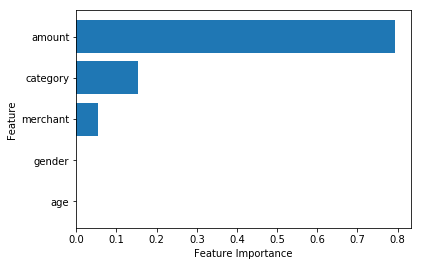

DEBUG:__main__:DT_PREDICTIONS are as follows 
:['0' '0' '0' ... '0' '0' '0']
DEBUG:__main__:Classification_report is : 
              precision    recall  f1-score   support

          0       1.00      0.96      0.98    176229
          1       0.22      0.97      0.35      2164

avg / total       0.99      0.96      0.97    178393

DEBUG:__main__:Confusion matrix is 
 [[168575   7654]
 [    58   2106]]
DEBUG:__main__:Ratio of classes before implementing sampling method: 
 Counter({'0': 411214, '1': 5036})
DEBUG:__main__:Ratio of classes after implementing sampling method: 
 Counter({'0': 411214, '1': 205607})


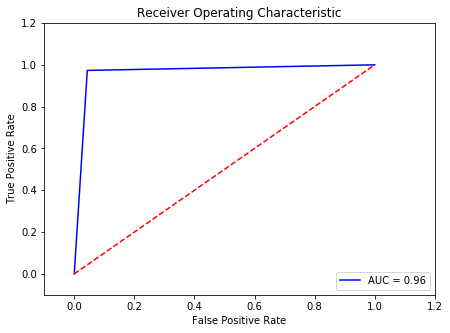

In [9]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn import metrics
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import Image

def DecisionTree(X_train, y_train, X_train_res, y_train_res, X_test, y_test):
    
    """ Implementing Decision Tree """
    dtc = DecisionTreeClassifier(random_state=0, class_weight="balanced",max_leaf_nodes = 10)
    X = pd.DataFrame(X_train_res)
    X.columns = X_train.columns
    y = pd.DataFrame(y_train_res)
    y.columns = ['fraud']
    dtc.fit(X,y)
#    pipeline_model = PMMLPipeline([('dtc',dtc)]).fit(X, y)
    input_dir = os.path.join(os.pardir, 'code')
#    sklearn2pmml(pipeline_model,os.path.join(input_dir,"FraudClassificationTree.pmml"), with_repr = True)

    logger.info('Implementing Decision tree')
    logger.info('Accuracy on the training subset: {:.3f}'.format(dtc.score(X_train_res, y_train_res)))
    logger.info('Accuracy on the test subset: {:.3f}'.format(dtc.score(X_test, y_test)))
        
    """ Feature Importance for DT """
    n_features = X_train_res.shape[1]
    plt.barh(range(n_features), dtc.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.rcParams["figure.figsize"] = (7,5)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.savefig('feature_imp_dt')
    plt.show()
    
    """ Generate predictions on test data using DT model """
    DT_predictions = dtc.predict(X_test)
    DT_predictions_proba = dtc.predict_proba(X_test)[:,1]
    logger.debug('DT_PREDICTIONS are as follows \n:{0}'.format(DT_predictions))
    
    """ Confusion Matrix for DT """
    confusion_mat = confusion_matrix((y_test), DT_predictions)
    logger.debug('Classification_report is : \n {0}'.format(classification_report((y_test), DT_predictions)))
    logger.debug('Confusion matrix is \n {0}'.format(confusion_mat))
    logger.debug('Ratio of classes before implementing sampling method: \n {0}'.format(Counter(y_train)))
    logger.debug('Ratio of classes after implementing sampling method: \n {0}'.format(Counter(y_train_res)))
    
    """ ROC Curve for DT """
    fpr, tpr, _ = metrics.roc_curve(pd.to_numeric(y_test), DT_predictions_proba.round())
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.rcParams["figure.figsize"] = (7,5)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('DT_ROC')
    plt.show()
    
    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_train.columns))
    png_bytes = graph.pipe(format='png')
    with open('dtree_pipe.png','wb') as f:
        f.write(png_bytes)
#    Image(png_bytes)    

    return
""" Implementing Decision Tree """
DecisionTree(X_train, y_train, X_train_res, y_train_res, X_test, y_test)

### Results
We have used AUC and accuracy as the metric to measure the performance of our model.As seen above, the model gives an accuracy of 95 percent on test data and AUC of 0.96. This shows that our model is performing well. In real time cases, the model usually doesn't perform that well because of the discrepancies in the data. Hence, data preprocessing plays a very main role in such cases. From the feature importance plot above, it is clear that 'gender' and 'age' are not important variables according to the model. We can rerun the model training by discarding these variables and again test the model. This is an iterative process of trial and error which ends when we are satisfied with our performance metrics like AUC and accuracy.